In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from Deep_Utils import sliding_window, inv_sliding_window
from Utils import logScaleSlices, inverseLogScaleSlices, downSampleSlices
from Metrics import ownPhaseMetricCorrected_numpy, ssimMetric, ownPhaseMetric_numpy
import os

In [1]:
root=r'D:\DLOCT\Cgansub_260123'
model_folder = '\\Nueva carpeta\cGAN_subsampling'
path = root+model_folder
savefolder = path
d_loss1 = np.load(path+'\d_loss1.npy')
d_loss2 = np.load(path+'\d_loss2.npy')
g_loss = np.load(path+'\g_loss.npy')
n_epochs = np.load(path+'\\n_epochs.npy')
fig,axs = plt.subplots(2,1)
axs[0].plot(d_loss1)
axs[0].plot(d_loss2)
axs[1].plot(g_loss)

NameError: name 'np' is not defined

In [3]:
""" Load tomograms"""
rootFolder = 'D:/DLOCT/TomogramsDataAcquisition/' # porcine cornea
fnameTom = 'ExperimentalTomogram/ExperimentalROI_corrected5' # porcine cornea

# rootFolder = 'D:/DLOCT/TDG/OCT_Real/nueva data/' # s.eye_swine
# fnameTom = '[p.SHARP][s.Eye2a][10-09-2019_13-14-42]_TomJones_z=(586)_x=(512)_y=(512)'# s.eye_swine

""" Shape of each tomogram, as tuples (Z, X, Y)"""

tomShape = [(350,384,384)]# porcine cornea
# tomShape = [(586,512,512)] # s.eye_swine

fnametom2 = 'ExperimentalTomogram/ExperimentalROI_corrected5_despeckled'
fname2 = rootFolder + fnametom2
fnameReal = fname2 + '_real.npy'
fnameImag = fname2 + '_imag.npy'
tomReal = np.load(fnameReal)
tomImag = np.load(fnameImag)

# fname = rootFolder + fnameTom
# # Names of all real and imag .bin files
# fnameTomReal = [fname + '_real.bin' ]
# fnameTomImag = [fname + '_imag.bin' ]
# tomReal = np.fromfile(fnameTomReal[0]) # quit single for porcine cornea and put single for s_eye ,dtype='single'
# tomReal = tomReal.reshape(tomShape[0], order='F')  # reshape using
# # Fortran style to import according to MATLAB

# tomImag = np.fromfile(fnameTomImag[0])
# tomImag = tomImag.reshape(tomShape[0], order='F')  # reshape using
# # Fortran style to import according to MATLAB

# tomData = np.stack((tomReal, tomImag), axis=3)
# # tomData = tomData/np.max(abs(tomData)) # normalize tomogram

In [4]:
n = 128
n1 = 128
window_size = (n,n)
stride = (n1,n1)
slices = []
zinit= int(np.round(tomShape[0][0]/2)-3)
zfinal= zinit + 6
#tomData=tomData[zinit:zfinal,:,:,:]
for b in range(6):
    i = b + zinit
    bslicei = sliding_window(tomImag[i,:,:],window_size,stride)
    bslicer = sliding_window(tomReal[i,:,:],window_size,stride)
    bslice = np.stack((bslicer,bslicei),axis=3)
    slices.append(bslice)
slices = np.array(slices)
slices = np.reshape(slices,(slices.shape[0]*slices.shape[1],slices.shape[2],slices.shape[3],slices.shape[4]))
del bslicei,bslicer,bslice
logslices, slicesMax, slicesMin = logScaleSlices(slices)
logslicesUnder = downSampleSlices(logslices)

In [5]:
samples = 4096
path_models = path + '\Models'
quanty_models = samples*100
path_models
models = os.listdir(path_models)

In [6]:
metrics = []
for i in models:
    print('__________ reading___________',i)
    model = tf.keras.models.load_model(path_models+'\\'+ i,compile=False)
    print('model loaded')
    logslicesOver = np.array(model.predict(logslicesUnder, batch_size=8), dtype='float64')
    slicesOver = inverseLogScaleSlices(logslicesOver, slicesMax, slicesMin)
    slicesUnder=downSampleSlices(slices)
    print('metrics evaluation')
    ssims = np.mean(ssimMetric(logslices, logslicesOver))
    phasemetric = np.mean(ownPhaseMetric_numpy(logslices, logslicesOver))
    phasemetricCorrected = np.mean(ownPhaseMetricCorrected_numpy(logslices, logslicesOver))
    mse = np.mean((logslices - logslicesOver)**2)
    epoch_metrics = np.array((ssims,phasemetric,phasemetricCorrected,mse))
    metrics.append(epoch_metrics)



__________ reading___________ model_004096.h5


c:\Users\diego\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


model loaded
16/16 [==============================] - 15s 840ms/step
metrics evaluation
__________ reading___________ model_008192.h5
model loaded
16/16 [==============================] - 13s 777ms/step
metrics evaluation
__________ reading___________ model_012288.h5
model loaded
16/16 [==============================] - 14s 802ms/step
metrics evaluation
__________ reading___________ model_016384.h5
model loaded
16/16 [==============================] - 14s 854ms/step
metrics evaluation
__________ reading___________ model_020480.h5
model loaded
16/16 [==============================] - 13s 764ms/step
metrics evaluation
__________ reading___________ model_024576.h5
model loaded
16/16 [==============================] - 13s 783ms/step
metrics evaluation
__________ reading___________ model_028672.h5
model loaded
16/16 [==============================] - 13s 784ms/step
metrics evaluation
__________ reading___________ model_032768.h5
model loaded
16/16 [==============================] - 15s 851m

In [8]:
metrics_log = np.array(metrics)
np.save(path+'\\metrics_log',metrics_log)

Text(0.5, 1.0, 'phase')

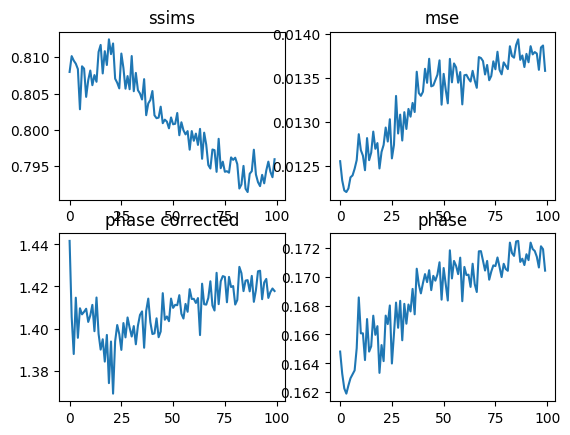

In [9]:
ssims = metrics_log[:,0]
phasemetric = metrics_log[:,1]
phasemetricCorrected = metrics_log[:,2]
mse = metrics_log[:,3]
fig,axs = plt.subplots(2,2)
axs[0,0].plot(ssims)
axs[0,0].set_title('ssims')
axs[0,1].plot(mse)
axs[0,1].set_title('mse')
axs[1,0].plot(phasemetricCorrected)
axs[1,0].set_title('phase corrected')
axs[1,1].plot(phasemetric)
axs[1,1].set_title('phase')

In [10]:
def max_value(array):
    max_val = array[0]  # initialize maximum value as the first element of the array
    max_pos = 0         # initialize maximum position as 0
    for i in range(1, len(array)):
        if array[i] > max_val:
            max_val = array[i]  # update maximum value
            max_pos = i         # update maximum position
    return max_val, max_pos

def min_value(array):
    min_val = array[0]  # initialize maximum value as the first element of the array
    min_pos = 0         # initialize maximum position as 0
    for i in range(1, len(array)):
        if array[i] < min_val:
            min_val = array[i]  # update maximum value
            min_pos = i         # update maximum position
    return min_val, min_pos

max_val, max_pos = max_value(ssims)
print(f"The maximum value of the ssim metric is {max_val} and its position is {max_pos}.")

min_val, min_pos = min_value(ssims)
print(f"The minimum value of the ssim metric is {min_val} and its position is {min_pos}.")

max_val, max_pos = max_value(mse)
print(f"The maximum value of the mse metric is {max_val} and its position is {max_pos}.")

min_val, min_pos = min_value(mse)
print(f"The minimum value of the mse metric is {min_val} and its position is {min_pos}.")

max_val, max_pos = max_value(phasemetric)
print(f"The maximum value of the phase metric is {max_val} and its position is {max_pos}.")

min_val, min_pos = min_value(phasemetric)
print(f"The minimum value of the phase metric is {min_val} and its position is {min_pos}.")

max_val, max_pos = max_value(phasemetricCorrected)
print(f"The maximum value of the phase metric corrected is {max_val} and its position is {max_pos}.")

min_val, min_pos = min_value(phasemetricCorrected)
print(f"The minimum value of the phase metric corrected is {min_val} and its position is {min_pos}.")

The maximum value of the ssim metric is 0.8124577430309221 and its position is 19.
The minimum value of the ssim metric is 0.7914660881818942 and its position is 86.
The maximum value of the mse metric is 0.013937747066770657 and its position is 86.
The minimum value of the mse metric is 0.01220340945638068 and its position is 3.
The maximum value of the phase metric is 0.17247737488641707 and its position is 86.
The minimum value of the phase metric is 0.16190243109004135 and its position is 3.
The maximum value of the phase metric corrected is 1.441634128084621 and its position is 0.
The minimum value of the phase metric corrected is 1.369130187861025 and its position is 21.


model = 81920
ssim = 0.8124577430309221
mse = 0.012471132177335528
phase corrected = 1.3741190385037476
phase = 0.16333993536865066


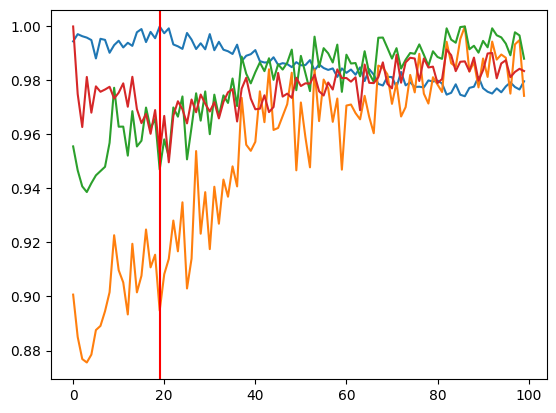

In [48]:
max_ssim, max_pos_ssim = max_value(ssims)
min_mse, min_pos_mse = min_value(mse)
min_phase, min_pos_phase = min_value(phasemetric)
ssims[3]-ssims[19]

model = 19
print('model =',(model+1)*samples)
print('ssim =',ssims[model])
print('mse =',mse[model])
print('phase corrected =',phasemetricCorrected[model])
print('phase =',phasemetric[model])
plt.plot(ssims/np.max(ssims))
plt.plot(mse/np.max(mse))
plt.plot(phasemetric/np.max(phasemetric))
plt.plot(phasemetricCorrected/np.max(phasemetricCorrected))
plt.axvline(x= model, color='r')

In [ ]:
n = 128
n1 = 128
window_size = (n,n)
stride = (n1,n1)
slices = []
zinit= int(np.round(tomShape[0][0]/2)-3)
zfinal= zinit + 6
for b in range(150):
    i = b
    bslicei = sliding_window(tomImag[i,:,:],window_size,stride)
    bslicer = sliding_window(tomReal[i,:,:],window_size,stride)
    bslice = np.stack((bslicer,bslicei),axis=3)
    slices.append(bslice)
slices = np.array(slices)
slices = np.reshape(slices,(slices.shape[0]*slices.shape[1],slices.shape[2],slices.shape[3],slices.shape[4]))
del bslicei,bslicer,bslice,tomImag,tomReal
logslices, slicesMax, slicesMin = logScaleSlices(slices)
logslicesUnder = downSampleSlices(logslices)
model = tf.keras.models.load_model(path_models+'\\'+ models[min_pos_mse],compile = False)

In [48]:
model = tf.keras.models.load_model(path_models+'\\'+ models[min_pos_mse],compile = False)

c:\Users\diego\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [51]:
logslicesOver = np.array(model.predict(logslicesUnder, batch_size=8), dtype='float64')
slicesOver = inverseLogScaleSlices(logslicesOver, slicesMax, slicesMin)

499/499 [==============================] - 331s 654ms/step


In [ ]:
print('\n\n\t\t\t --- Quantitative metrics log scale ---\n')

ssims = np.mean(ssimMetric(logslices, logslicesOver))
phasemetric = np.mean(ownPhaseMetric_numpy(logslices, logslicesOver))
phasemetricCorrected = np.mean(ownPhaseMetricCorrected_numpy(logslices, logslicesOver))
mse = np.mean((logslices - logslicesOver)**2)

print('\t\t -- For test data')
print('MSE: ', mse)
print('Phase STD [0, 1]: ', phasemetric)
print('Phase STD [-1, 1]: ', phasemetricCorrected)
print('SSIM: ', ssims)
